In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel,get_linear_schedule_with_warmup
from torch.utils.data import DataLoader,Dataset
import numpy as np
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [2]:
df = pd.read_csv("C:/ml/data.csv",delimiter=',')
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [3]:
print(df.isnull().sum())
print(df.duplicated().sum())

Sentence     0
Sentiment    0
dtype: int64
6


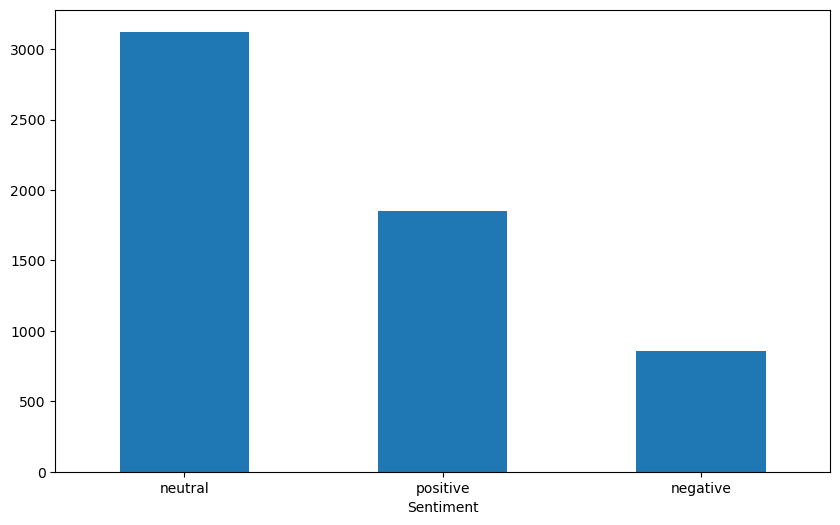

In [4]:
df.drop_duplicates(inplace=True)

plt.figure(figsize=(10,6))
df['Sentiment'].value_counts().plot(kind='bar',rot=0)
plt.show()




In [5]:
### changing the labels into numerical values and importing bert tokenizer


df['Sentiment'] = df['Sentiment'].map({"negative":0,"neutral":1,"positive":2})


MODEL_NAME = 'bert-base-cased'


tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer.encode("I love apples Ice cream and all sorts of fun stuff")
tokenizer.sep_token,tokenizer.sep_token_ids
tokenizer.cls_token,tokenizer.cls_token_ids




('[CLS]', 101)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


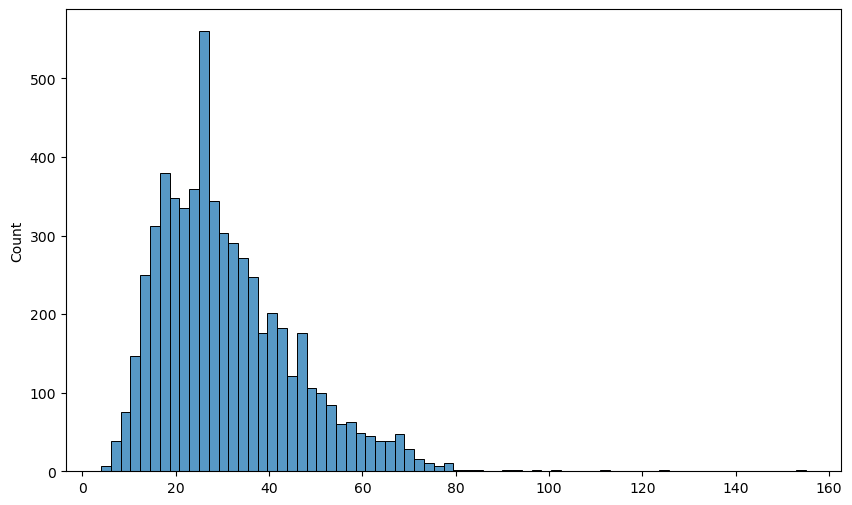

In [6]:

sample_tokens = []
for txt in df['Sentence']:
    tokens = tokenizer.encode(txt, max_length=512)
    sample_tokens.append(len(tokens))



plt.figure(figsize=(10,6))
sns.histplot(sample_tokens)
plt.show()


In [7]:

MAX_LEN = 140


class Finance_Dataset(Dataset):
    def __init__(self,Sentence,targets,max_len,tokenizer):
        self.Sentence = Sentence
        self.targets = targets
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.Sentence)
    
    
    def __getitem__(self,idx):
        Sentence = str(self.Sentence[idx])
        target = self.targets[idx]
        
        
        encoder = self.tokenizer.encode_plus(
            Sentence,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            )
        
        return {
            "Sentence":Sentence,
            "input_ids":encoder['input_ids'].flatten(),
            "attention_mask":encoder['attention_mask'].flatten(),
            "targets":torch.tensor(target,dtype=torch.long),
            }
    



from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test,test_size=.40,random_state=42)

BATCH_SIZE = 16

def get_dataloader(df,max_len,tokenizer,batch_size):
    ds = Finance_Dataset(
    Sentence = df['Sentence'].to_numpy(),
    targets = df['Sentiment'].to_numpy(),
    max_len=max_len,
    tokenizer=tokenizer
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
        )


train_dataloader = get_dataloader(df_train, max_len=MAX_LEN, tokenizer=tokenizer, batch_size=BATCH_SIZE)
test_dataloader = get_dataloader(df_test,max_len=MAX_LEN,tokenizer=tokenizer,batch_size=BATCH_SIZE)
val_dataloader = get_dataloader(df_val, max_len=MAX_LEN, tokenizer=tokenizer, batch_size=BATCH_SIZE)

data = next(iter(train_dataloader))
print(data.keys())

dict_keys(['Sentence', 'input_ids', 'attention_mask', 'targets'])


In [8]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 140])
torch.Size([16, 140])
torch.Size([16])


In [9]:

attention_mask = data['attention_mask']
input_ids = data['input_ids']


model = BertModel.from_pretrained(MODEL_NAME)


### nn for Bert Transformer for text classification

class Bert_Classifier(nn.Module):
    def __init__(self, n_classes=3):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(768,3)
    

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)



model = Bert_Classifier(3).to(device)
model                             

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [10]:

optimizer = torch.optim.AdamW(params = model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
EPOCHS = 3
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [11]:

def training_epoch(model,dataloader,loss_fn,optimizer,device,scheduler,n_examples):
    model.train()
    losses = []
    predictions = 0
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            attention_mask=attention_mask,
            input_ids=input_ids
            )
        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return (predictions.double() / n_examples,np.mean(losses))




def eval_model(model,dataloader,loss_fn,device,n_examples):
    model = model.eval()
    losses = []
    predictions = 0
    
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
                )
            
            _,preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return (predictions.double() / n_examples,np.mean(losses))

In [12]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    train_acc, train_loss = training_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train accuracy {train_acc} --train loss-- {train_loss}')

    val_acc, val_loss = eval_model(model,val_dataloader,loss_fn,device,len(df_val))
    print(f'Val accuracy {val_acc} val loss {val_loss}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  



test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Testing Accuracy : {test_acc.item() *100 :.2f}%')

Epoch 1/ 3
Train accuracy 0.6773778920308484 --train loss-- 0.7032401939879541
Val accuracy 0.7985714285714286 val loss 0.43994066694920714
Epoch 2/ 3
Train accuracy 0.8157669237360754 --train loss-- 0.4088990642906052
Val accuracy 0.8057142857142857 val loss 0.40701135332611477
Epoch 3/ 3
Train accuracy 0.8590402742073694 --train loss-- 0.296154219631667
Val accuracy 0.8028571428571428 val loss 0.42974977322261443
Testing Accuracy : 78.21%


In [14]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    return all_labels, all_preds





true_labels, predicted_labels = get_predictions(model, test_dataloader, device)

clf_rpt = classification_report(true_labels,predicted_labels)
print(f'Classification Report: {clf_rpt}')

acc = accuracy_score(true_labels,predicted_labels)
print(f' --Accuracy Score-- {acc*100:.2f}')

Classification Report:               precision    recall  f1-score   support

           0       0.47      0.43      0.45        60
           1       0.83      0.84      0.84       276
           2       0.82      0.81      0.81       132

    accuracy                           0.78       468
   macro avg       0.71      0.70      0.70       468
weighted avg       0.78      0.78      0.78       468

 --Accuracy Score-- 78.21


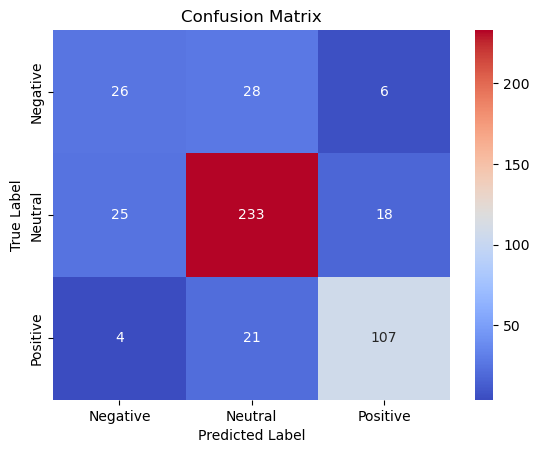

In [15]:
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


plot_confusion_matrix(true_labels, predicted_labels)